In [1]:
import pickle
import pandas as pd
import numpy as np
from math import dist
from numpy import linspace
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import roc_curve
from textwrap import wrap
import shutil, errno
import os
from os import listdir
from sklearn.metrics import auc
import matplotlib.patches as mpatches
import xgboost
%matplotlib inline
from matplotlib.lines import Line2D

### Pose AI Performance

In [2]:
with open('training_preds_gts.pickle', 'rb') as handle: #Loading in ground truths and model predictions on training dataset
    training_gt,training_pds,training_ref_distances=pickle.load(handle)
    
with open('frames_preds_gts.pickle', 'rb') as handle: #Loading in ground truths and model predictions on held-out frames dataset
    frames_gt,frames_pds,frames_ref_distances=pickle.load(handle)

with open('babies_preds_gts.pickle', 'rb') as handle: #Loading in ground truths and model predictions on held-out babies dataset
    babies_gt,babies_pds,babies_ref_distances=pickle.load(handle)
    
#Structure of gt and pds lists: shape is 2 x 14 x n 
    #denoting X vs Y coordinate (1 or 2), which body part (1 through 14), and the value (1 through n)

In [3]:
#Creating dataframe of L2 error values for each ground truth, model prediction pair from training dataset
training_l2_error_dataset=[]
for bodypart_x_gts,bodypart_y_gts, bodypart_x_pds,bodypart_y_pds in zip(training_gt[0],training_gt[1], training_pds[0],
                                                                       training_pds[1]):
    
    bodypart_l2_errors=[]
    for bodypart_x_gt_coordinate,bodypart_y_gt_coordinate, bodypart_x_pd_coordinate,bodypart_y_pd_coordinate in zip(bodypart_x_gts,bodypart_y_gts, bodypart_x_pds,bodypart_y_pds):
    
        bodypart_l2_errors+=[dist((bodypart_x_gt_coordinate,bodypart_y_gt_coordinate),(bodypart_x_pd_coordinate,bodypart_y_pd_coordinate))]
    training_l2_error_dataset+=[bodypart_l2_errors]
    
training_l2_error_dataset=list(map(list, zip(*training_l2_error_dataset)))

training_l2_df=pd.DataFrame(data=training_l2_error_dataset, columns=['Nose', 'Neck', 'ShoulderR', 'ElbowR', 'HandR',
       'ShoulderL', 'ElbowL', 'HandL', 'HipR', 'KneeR', 'FootR', 'HipL',
       'KneeL', 'FootL'])

In [4]:
#Creating dataframe of L2 error values for each ground truth, model prediction pair from held-out frames dataset
frames_l2_error_dataset=[]
for bodypart_x_gts,bodypart_y_gts, bodypart_x_pds,bodypart_y_pds in zip(frames_gt[0],frames_gt[1], frames_pds[0],
                                                                       frames_pds[1]):
    
    bodypart_l2_errors=[]
    for bodypart_x_gt_coordinate,bodypart_y_gt_coordinate, bodypart_x_pd_coordinate,bodypart_y_pd_coordinate in zip(bodypart_x_gts,bodypart_y_gts, bodypart_x_pds,bodypart_y_pds):
    
        bodypart_l2_errors+=[dist((bodypart_x_gt_coordinate,bodypart_y_gt_coordinate),(bodypart_x_pd_coordinate,bodypart_y_pd_coordinate))]
    frames_l2_error_dataset+=[bodypart_l2_errors]
    
frames_l2_error_dataset=list(map(list, zip(*frames_l2_error_dataset)))

frames_l2_df=pd.DataFrame(data=frames_l2_error_dataset, columns=['Nose', 'Neck', 'ShoulderR', 'ElbowR', 'HandR',
       'ShoulderL', 'ElbowL', 'HandL', 'HipR', 'KneeR', 'FootR', 'HipL',
       'KneeL', 'FootL'])

In [5]:
#Creating dataframe of L2 error values for each ground truth, model prediction pair from held-out babies dataset
babies_l2_error_dataset=[]
for bodypart_x_gts,bodypart_y_gts, bodypart_x_pds,bodypart_y_pds in zip(babies_gt[0],babies_gt[1], babies_pds[0],
                                                                       babies_pds[1]):
    
    bodypart_l2_errors=[]
    for bodypart_x_gt_coordinate,bodypart_y_gt_coordinate, bodypart_x_pd_coordinate,bodypart_y_pd_coordinate in zip(bodypart_x_gts,bodypart_y_gts, bodypart_x_pds,bodypart_y_pds):
    
        bodypart_l2_errors+=[dist((bodypart_x_gt_coordinate,bodypart_y_gt_coordinate),(bodypart_x_pd_coordinate,bodypart_y_pd_coordinate))]
    babies_l2_error_dataset+=[bodypart_l2_errors]
    
babies_l2_error_dataset=list(map(list, zip(*babies_l2_error_dataset)))

babies_l2_df=pd.DataFrame(data=babies_l2_error_dataset, columns=['Nose', 'Neck', 'ShoulderR', 'ElbowR', 'HandR',
       'ShoulderL', 'ElbowL', 'HandL', 'HipR', 'KneeR', 'FootR', 'HipL',
       'KneeL', 'FootL'])

In [6]:
#Rearranging dataframe format to fit dictionary format
training_distances=dict()
frames_distances=dict()
babies_distances=dict()

for column in [i for i in  training_l2_df.columns if i!='MRN' if i!='Image']:
    training_distances[column]=[i for i in training_l2_df[column].values if i==i]
    
for column in [i for i in  frames_l2_df.columns if i!='MRN' if i!='Image']:
    frames_distances[column]=[i for i in frames_l2_df[column].values if i==i]
    
for column in [i for i in  babies_l2_df.columns if i!='MRN' if i!='Image']:
    babies_distances[column]=[i for i in babies_l2_df[column].values if i==i]

C:\Users\AlecG\AppData\Local\Temp\ipykernel_38472\2681701435.py:172: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


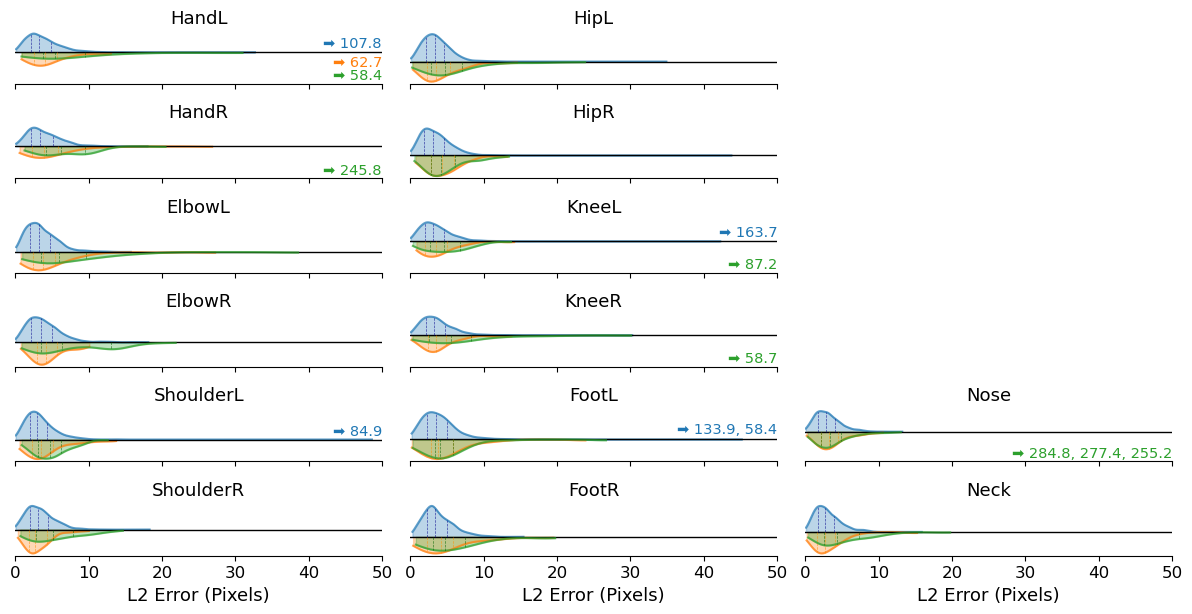

In [7]:
#Creating density plots of L2 error across training, held-out frames, and held-out babies datasets
training_distances_use=dict()
frames_distances_use=dict()
babies_distances_use=dict()

training_distances_outliers=dict()
frames_distances_outliers=dict()
babies_distances_outliers=dict()


fig, axs = plt.subplots(nrows=6,ncols=3,sharex=False,sharey=False,layout='constrained')
fig.set_size_inches(12, 6)
4,12

ax_xi=0
ax_yi=0
for bodypart in ['HandL','HandR','ElbowL','ElbowR','ShoulderL','ShoulderR',
                'HipL','HipR','KneeL','KneeR','FootL','FootR',
                'Nose','Neck']:
    
    
    
    if (ax_yi!=2) or (ax_yi==2 and ax_xi>3):
    
        training_distances_outliers[bodypart]= [i for i in training_distances[bodypart] if i>50]
        training_distances_use[bodypart] = [i for i in training_distances[bodypart] if i<=50]
        
        frames_distances_outliers[bodypart]= [i for i in frames_distances[bodypart] if i>50]
        frames_distances_use[bodypart] = [i for i in frames_distances[bodypart] if i<=50]
        
        babies_distances_outliers[bodypart]= [i for i in babies_distances[bodypart] if i>50]
        babies_distances_use[bodypart] = [i for i in babies_distances[bodypart] if i<=50]
    
        axs[ax_xi,ax_yi].spines[['right', 'top','left']].set_visible(False)
        axs[ax_xi,ax_yi].get_yaxis().set_visible(False)
        # plot density chart for var1
        x_range_training=linspace(min(training_distances_use[bodypart]), max(training_distances_use[bodypart]), len(training_distances_use[bodypart]))
        kde_training=gaussian_kde(training_distances_use[bodypart])
        
        sns.lineplot(x=x_range_training, y=kde_training(x_range_training), color='#1f77b4', ax=axs[ax_xi,ax_yi],alpha=0.7) 
        axs[ax_xi,ax_yi].fill_between(x_range_training, kde_training(x_range_training), color='#1f77b4',label='Training',alpha=0.3)
        
        
        # plot density chart for var2
        kde_frames = gaussian_kde(frames_distances_use[bodypart])
        x_range_frames = linspace(min(frames_distances_use[bodypart]), max(frames_distances_use[bodypart]), len(frames_distances_use[bodypart]))
        
        # multiply by -1 to reverse axis (mirror plot)
        sns.lineplot(x=x_range_frames, y=kde_frames(x_range_frames) * -1, color='#ff7f0e', ax=axs[ax_xi,ax_yi],alpha=0.7) 
        axs[ax_xi,ax_yi].fill_between(x_range_frames, kde_frames(x_range_frames) * -1, color='#ff7f0e',label='frames',alpha=0.3)
        
        # add axis names        
        axs[ax_xi,ax_yi].axhline(y=0, linestyle='-',linewidth=1, color='black')
        
        
        axs[ax_xi,ax_yi].set_title(bodypart[0].upper()+bodypart[1:],fontsize=13)
        
        #For plotting CK vals
        center=max(kde_frames(x_range_frames))*1.25
        
        out_of=max(kde_frames(x_range_frames))+max(kde_training(x_range_training))
    
        
        axs[ax_xi,ax_yi].vlines(np.percentile(training_distances_use[bodypart], 25), 0, kde_training(np.percentile(training_distances_use[bodypart], 25))[0],color='darkblue',lw=0.5,ls='dashed',alpha=0.7)   
        axs[ax_xi,ax_yi].vlines(np.percentile(training_distances_use[bodypart], 50), 0, kde_training(np.percentile(training_distances_use[bodypart], 50))[0],color='darkblue',lw=0.5,ls='dashed',alpha=0.7)   
        axs[ax_xi,ax_yi].vlines(np.percentile(training_distances_use[bodypart], 75), 0, kde_training(np.percentile(training_distances_use[bodypart], 75))[0],color='darkblue',lw=0.5,ls='dashed',alpha=0.7)   
    
    
        axs[ax_xi,ax_yi].vlines(np.percentile(frames_distances_use[bodypart], 25), 0, -kde_frames(np.percentile(frames_distances_use[bodypart], 25))[0],color='darkorange',lw=0.5,ls='dashed',alpha=0.7)   
        axs[ax_xi,ax_yi].vlines(np.percentile(frames_distances_use[bodypart], 50), 0, -kde_frames(np.percentile(frames_distances_use[bodypart], 50))[0],color='darkorange',lw=0.5,ls='dashed',alpha=0.7)   
        axs[ax_xi,ax_yi].vlines(np.percentile(frames_distances_use[bodypart], 75), 0, -kde_frames(np.percentile(frames_distances_use[bodypart], 75))[0],color='darkorange',lw=0.5,ls='dashed',alpha=0.7)   
    
        
        kde_babies = gaussian_kde(babies_distances_use[bodypart])
        x_range_babies = linspace(min(babies_distances_use[bodypart]), max(babies_distances_use[bodypart]), len(babies_distances_use[bodypart]))
        
        # multiply by -1 to reverse axis (mirror plot)
        sns.lineplot(x=x_range_babies, y=kde_babies(x_range_babies) * -1, color='#2ca02c', ax=axs[ax_xi,ax_yi],alpha=0.7) 
        axs[ax_xi,ax_yi].fill_between(x_range_babies, kde_babies(x_range_babies) * -1, color='#2ca02c',label='New Babies',alpha=0.3)
        
        axs[ax_xi,ax_yi].vlines(np.percentile(babies_distances_use[bodypart], 25), 0, -kde_babies(np.percentile(babies_distances_use[bodypart],25))[0],color='darkgreen',lw=0.5,ls='dashed',alpha=0.7)   
        axs[ax_xi,ax_yi].vlines(np.percentile(babies_distances_use[bodypart], 50), 0, -kde_babies(np.percentile(babies_distances_use[bodypart],50))[0],color='darkgreen',lw=0.5,ls='dashed',alpha=0.7)   
        axs[ax_xi,ax_yi].vlines(np.percentile(babies_distances_use[bodypart], 75), 0, -kde_babies(np.percentile(babies_distances_use[bodypart],75))[0],color='darkgreen',lw=0.5,ls='dashed',alpha=0.7)   
        
        axs[ax_xi,ax_yi].get_legend().remove()
    
        
        
        if len(training_distances_outliers[bodypart])>0:
            starting=50
            string=''
            for i in training_distances_outliers[bodypart]:
                if len(string)>0:
                    string+=', '
                string+=str(round(i,1))
                
            
            top=0.1
            
            if len(babies_distances_outliers[bodypart])==0:
                top=0.07
            
            axs[ax_xi,ax_yi].text(starting,top,'➡️ '+string,
                 fontsize=10.5, color='#1f77b4',verticalalignment='center', horizontalalignment='right')  
            
            #Accounting for height of plots and room for outlier values
            axs[ax_xi,ax_yi].set_ylim(None, np.max([max(kde_training(x_range_training))+0.02,0.2]))
            
        if len(frames_distances_outliers[bodypart])>0:
            starting=50
            string=''
            for i in frames_distances_outliers[bodypart]:
                if len(string)>0:
                    string+=', '
                string+=str(round(i,1))
                
            
            axs[ax_xi,ax_yi].text(starting,-0.11,'➡️ '+string,
                 fontsize=10.5, color='#ff7f0e',verticalalignment='center', horizontalalignment='right')
            
            
            
            
            #Accounting for height of plots and room for outlier values
            axs[ax_xi,ax_yi].set_ylim(np.min([-max(kde_frames(x_range_training))-0.02,-0.2]), None)
            
        if len(babies_distances_outliers[bodypart])>0:
            starting=50
            string=''
            for i in babies_distances_outliers[bodypart]:
                if len(string)>0:
                    string+=', '
                string+=str(round(i,1))
                
                
            axs[ax_xi,ax_yi].text(starting,-0.26,'➡️ '+string,
                 fontsize=10.5, color='#2ca02c',verticalalignment='center', horizontalalignment='right')
            
            #Accounting for height of plots and room for outlier values
            axs[ax_xi,ax_yi].set_ylim(np.min([-max(kde_babies(x_range_training))-0.02,-0.35]), None)
            
        
    
    for val in range(4):
        axs[val,2].spines[['right', 'top','left','bottom']].set_visible(False)
        axs[val,2].set_xticks([])
        axs[val,2].set_yticks([])

    axs[ax_xi,ax_yi].set_xlim(0,50)
    if ax_xi!=5:
        axs[ax_xi,ax_yi].set_xticks([0,10,20,30,40,50], [None,None,None,None,None,None])

    
    ax_xi+=1
    if (ax_xi+1)%7==0:
        
        if ax_yi<2:
            ax_yi+=1
            ax_xi=0
        
    if (ax_yi==2)&(ax_xi==0):
        ax_xi=4
        
    if (ax_yi==2)&(ax_xi==6):
        ax_xi=0

        
        
    # show the graph

plt.xlim(0,50)
plt.tight_layout()

axs[5,0].set_xlabel('L2 Error (Pixels)',fontsize=13)
axs[5,1].set_xlabel('L2 Error (Pixels)',fontsize=13)
axs[5,2].set_xlabel('L2 Error (Pixels)',fontsize=13)

axs[5,0].tick_params(axis='x', labelsize=12)
axs[5,1].tick_params(axis='x', labelsize=12)
axs[5,2].tick_params(axis='x', labelsize=12)


plt.show()

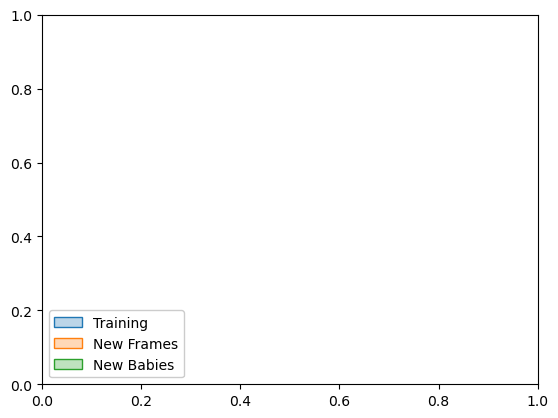

In [8]:
training_patch = mpatches.Patch(color=(31/255, 119/255, 180/255,0.3),ec=(31/255, 119/255, 180/255,1), label='Training') 
frames_patch = mpatches.Patch(color=(255/255, 127/255, 14/255,0.3),ec=(255/255, 127/255, 14/255,1),label='New Frames') 
babies_patch = mpatches.Patch(color=(44/255, 160/255, 44/255,0.3),ec=(44/255, 160/255, 44/255,1), label='New Babies') 

handles=[training_patch,frames_patch,babies_patch]

f = lambda m,c: plt.plot([],[],marker=m, ls="none")[0]
legend = plt.legend(handles, ['Training','New Frames','New Babies'], loc=3, framealpha=1, frameon=True)

plt.show()

In [9]:
#Function to scale list values (for PCK thresholds) to range from 0 to 1, plotting purposes
def scale01(X, d=None):
    X = np.array(X, dtype=float)
    if d is None:
        X = scaleAB(X, 0, 1)
    else:
        X = scaleAB(X, 0, 1, d)
    return X

def scaleAB(X, A, B, d=None):
    if d is None:
        X = (X - np.min(X)) / (np.max(X) - np.min(X))
        X = X * (B - A) + A
    else:
        d = np.mod(d, X.ndim) + 1
        minvals = np.min(X, axis=d, keepdims=True)
        maxvals = np.max(X, axis=d, keepdims=True)
        X = (X - minvals) / (maxvals - minvals)
        X = X * (B - A) + A
    return X

In [10]:
#Get distance between predictions and ground truths, relative to reference distance (for PCK calculation)
def getDistPCKh(pred, gt, refDist):
    assert pred.shape[0] == gt.shape[0] and pred.shape[1] == gt.shape[1] and pred.shape[2] == gt.shape[2]
    assert refDist.shape[0] == gt.shape[2]

    dist = np.empty((1, pred.shape[1], pred.shape[2]))
    dist.fill(np.nan)

    for imgidx in range(pred.shape[2]):
        # distance to gt joints
        dist[0, :, imgidx] = np.sqrt(np.sum(np.square(pred[:, :, imgidx] - gt[:, :, imgidx]), axis=0)) / refDist[imgidx]

    return dist

#PCK calculation
def computePCK(dist, the_range):
    pck = np.zeros((dist.shape[1] + 3,len(the_range)))

    
    #jidx = bodypart (1 of 14)
    for jidx in range(dist.shape[1]):
        # compute PCK for each threshold
        for k in range(len(the_range)):
            d = np.squeeze(dist[0, jidx, :])
            pck[jidx,k] = 100 * np.mean(d[~np.isnan(d)] <= the_range[k])
    
    #compute PCK lower body (14th index)
    for k in range(len(the_range)):
        d = np.reshape(np.squeeze(dist[0, 8:14, :]), (6*dist.shape[2], 1))
        pck[-3,k] = 100 * np.mean(d[~np.isnan(d)] <= the_range[k])
    
    #compute PCK upper body (15th index)
    for k in range(len(the_range)):
        d = np.reshape(np.squeeze(dist[0, 0:7, :]), (7*dist.shape[2], 1))
        pck[-2,k] = 100 * np.mean(d[~np.isnan(d)] <= the_range[k])
    
    #compute PCK full body (16th index)
    for k in range(len(the_range)):
        d = np.reshape(np.squeeze(dist[0, :, :]), (dist.shape[1]*dist.shape[2], 1))
        pck[-1,k] = 100 * np.mean(d[~np.isnan(d)] <= the_range[k])

    return pck

In [11]:
the_range = np.arange(0, 0.5, 0.01) #Range of thresholds relative to reference distance (up to half the length of baby head)

In [12]:
refDist=np.array(training_ref_distances) #Reference distances for training dataset

distances_training=getDistPCKh(training_pds,training_gt,refDist)
pck_training=computePCK(distances_training, the_range)

In [13]:
refDist=np.array(frames_ref_distances) #Reference distances for held-out frames dataset

distances_frames=getDistPCKh(frames_pds,frames_gt,refDist)
pck_frames=computePCK(distances_frames, the_range)

In [14]:
refDist=np.array(babies_ref_distances) #Reference distances for held-out babies dataset

distances_babies=getDistPCKh(babies_pds,babies_gt,refDist)
pck_babies=computePCK(distances_babies, the_range)

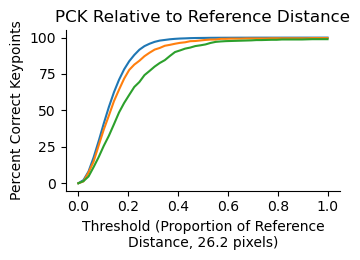

In [15]:
#Plotting PCK for training dataset, and held-out frames and babies datasets
fig, ax = plt.subplots(figsize=(3.6, 2.7))


for pck,label in zip([pck_training,pck_frames,pck_babies],['Training','frames','New Babies']):


    ax.plot(scale01(the_range), pck[16],  label=label)

    ax.spines[['right', 'top']].set_visible(False)


    ax.set_xlabel("\n".join(wrap("Threshold (Proportion of Reference Distance, {:0.1f} pixels)".format(52.4054/2),40)))
    ax.set_ylabel('Percent Correct Keypoints')
    
y_pos = ax.xaxis.get_label().get_position()[1]-0.9
bbox = ax.xaxis.get_label().get_window_extent()
x_pos = 1
# get the text bounding box


plt.title("PCK Relative to Reference Distance")

    
plt.tight_layout()

In [16]:
with open('training_occlusion.pickle', 'rb') as handle: #Occlusion status, and model prediction of occlusion for training dataset
    full_body_training_occlusion_CK,full_body_training_occlusion_confidence=pickle.load(handle)
with open('frames_occlusion.pickle', 'rb') as handle: #Occlusion status, and model prediction of occlusion for held-out frames dataset
    full_body_frames_occlusion_CK,full_body_frames_occlusion_confidence=pickle.load(handle)
with open('babies_occlusion.pickle', 'rb') as handle: #Occlusion status, and model prediction of occlusion for held-out babies dataset
    full_body_babies_occlusion_CK,full_body_babies_occlusion_confidence=pickle.load(handle)

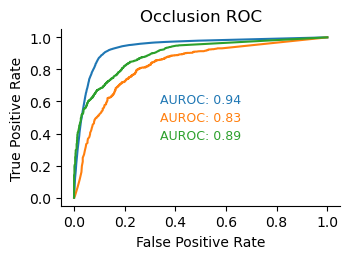

In [17]:
#Plotting ROC Curves for Occlusion prediction on all datasets
fig, ax = plt.subplots(figsize=(3.6, 2.7))


for AUROC,label in zip([[full_body_training_occlusion_CK,full_body_training_occlusion_confidence],
                        [full_body_frames_occlusion_CK,full_body_frames_occlusion_confidence],
                       [full_body_babies_occlusion_CK,full_body_babies_occlusion_confidence]],['Training','frames','New Babies']):

    fpr, tpr, thresholds = roc_curve(AUROC[0],AUROC[1])
    
    ax.plot(fpr, tpr,  label=label)
        
    ax.spines[['right', 'top']].set_visible(False)
        
        
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel('True Positive Rate')    

    
handles, labels = ax.get_legend_handles_labels()

colors_handles = [i.get_color() for i in handles]

index=0


for AUROC,col in zip([[full_body_training_occlusion_CK,full_body_training_occlusion_confidence],
                        [full_body_frames_occlusion_CK,full_body_frames_occlusion_confidence],
                       [full_body_babies_occlusion_CK,full_body_babies_occlusion_confidence]],colors_handles):
    
    fpr, tpr, thresholds = roc_curve(AUROC[0],AUROC[1])
    ax.text(0.5, 0.6-index*0.1, 'AUROC: {:0.2f}'.format(auc(fpr, tpr)), horizontalalignment='center',color=col, verticalalignment='center',transform=ax.transAxes, fontsize=9)
    index+=1

plt.title("Occlusion ROC")
    
plt.tight_layout()

    

### Cerebral Dysfunction and Sedation Classifier Performance/Statistics

In [18]:
with open('sedation_model_results.pickle', 'rb') as file: #Contains TPR and FPR values for sedation classifier
    xgboost_sedation=pickle.load(file)
with open('cerebral_model_results.pickle', 'rb') as file: #Contains TPR and FPR values for cerebral dysfunction classifier
    xgboost_cerebral=pickle.load(file)

with open('sedation_cross_validation_stats.pickle', 'rb') as file: #Contains TPR and FPR values for sedation classifier cross-validation
    cross_validation_values_sedation=pickle.load(file)
with open('cerebal_cross_validation_stats.pickle', 'rb') as file: #Contains TPR and FPR values for cerebal dysfunction classifier cross-validation
    cross_validation_values_cerebral=pickle.load(file)

In [19]:
xgboost_sedation

{'held_out_frames_performance': {'tpr': array([0.00000000e+00, 3.02388872e-04, 8.46688842e-03, ...,
         9.99697611e-01, 1.00000000e+00, 1.00000000e+00]),
  'fpr': array([0.        , 0.        , 0.        , ..., 0.81293189, 0.81293189,
         1.        ])},
 'held_out_babies_performance': {'tpr': array([0.00000000e+00, 1.10926234e-04, 8.87409872e-04, ...,
         9.98668885e-01, 9.98668885e-01, 1.00000000e+00]),
  'fpr': array([0.        , 0.        , 0.        , ..., 0.99968394, 1.        ,
         1.        ])}}

In [20]:
#Calculating median sedation classifier cross-validation performance on training dataset and 95% confidence interval
combined_tprs_frames_sedation = []
base_fpr_sedation = np.linspace(
    0, 1, 101)


for tpr,fpr in zip(cross_validation_values_sedation['train_stats']['tprs'],cross_validation_values_sedation['train_stats']['fprs']):
    tpr = np.interp(base_fpr_sedation, fpr, tpr)
    tpr[0] = 0.0
    combined_tprs_frames_sedation+=[tpr]
            
median_tpr_sedation=[[np.median(np.array(combined_tprs_frames_sedation)[:,i]) for i in range(len(base_fpr_sedation))]][0]
lower_quintile_tpr_sedation=[[np.percentile(np.array(combined_tprs_frames_sedation)[:,i],2.5) for i in range(len(base_fpr_sedation))]][0]
upper_quintile_tpr_sedation=[[np.percentile(np.array(combined_tprs_frames_sedation)[:,i],97.5) for i in range(len(base_fpr_sedation))]][0]

In [21]:
#Calculating median cerebral dysfunction classifier cross-validation performance on training dataset and 95% confidence interval
combined_tprs_frames_cerebral = []
base_fpr_cerebral = np.linspace(0, 1, 101)


for tpr,fpr in zip(cross_validation_values_cerebral['train_stats']['tprs'],cross_validation_values_cerebral['train_stats']['fprs']):
    tpr = np.interp(base_fpr_cerebral, fpr, tpr)
    tpr[0] = 0.0
    combined_tprs_frames_cerebral+=[tpr]
            
median_tpr_cerebral=[[np.median(np.array(combined_tprs_frames_cerebral)[:,i]) for i in range(len(base_fpr_cerebral))]][0]
lower_quintile_tpr_cerebral=[[np.percentile(np.array(combined_tprs_frames_cerebral)[:,i],2.5) for i in range(len(base_fpr_cerebral))]][0]
upper_quintile_tpr_cerebral=[[np.percentile(np.array(combined_tprs_frames_cerebral)[:,i],97.5) for i in range(len(base_fpr_cerebral))]][0]

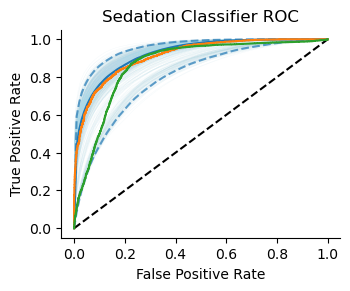

In [22]:
#Plotting sedation classifier ROC curves
fig, ax = plt.subplots(1,1,figsize=(3.6, 2.7))

x_ticks=[]


for tpr,fpr in zip(cross_validation_values_sedation['train_stats']['tprs'],cross_validation_values_sedation['train_stats']['fprs']):
    plt.plot(fpr, tpr, color='lightblue',alpha=0.2, linewidth=0.2)
plt.plot(cross_validation_values_sedation['train_stats']['base_fpr'], median_tpr_sedation, color='#1f77b4')
plt.plot(cross_validation_values_sedation['train_stats']['base_fpr'], lower_quintile_tpr_sedation, linestyle='--', color='#1f77b4',alpha=0.7)
plt.plot(cross_validation_values_sedation['train_stats']['base_fpr'], upper_quintile_tpr_sedation, linestyle='--', color='#1f77b4',alpha=0.7)


plt.plot([0,1], [0,1], linestyle='--', color='black')

for key,color in zip([
            xgboost_sedation['held_out_frames_performance'],
            xgboost_sedation['held_out_babies_performance']
            ],
            ['#ff7f0e','#2ca02c']):
    try:
        plt.plot(key['fpr'],key['tpr'],color=color)
    except:
        plt.plot(key['base_fpr'],key['mean_tprs'],color=color)
    
plt.ylabel('True Positive Rate')

plt.xlabel('False Positive Rate')
ax.spines[['right', 'top']].set_visible(False)

plt.title('Sedation Classifier ROC')
plt.show()

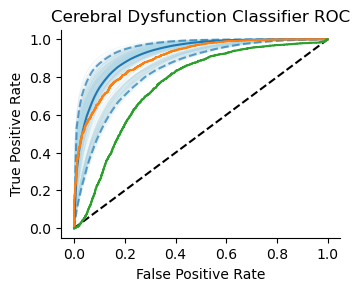

In [23]:
#Plotting cerebral dysfunction classifier ROC curves
fig, ax = plt.subplots(1,1,figsize=(3.6, 2.7))

x_ticks=[]


for tpr,fpr in zip(cross_validation_values_cerebral['train_stats']['tprs'],cross_validation_values_cerebral['train_stats']['fprs']):
    plt.plot(fpr, tpr, color='lightblue',alpha=0.2, linewidth=0.2)
plt.plot(cross_validation_values_cerebral['train_stats']['base_fpr'], median_tpr_cerebral, color='#1f77b4')
plt.plot(cross_validation_values_cerebral['train_stats']['base_fpr'], lower_quintile_tpr_cerebral, linestyle='--', color='#1f77b4',alpha=0.7)
plt.plot(cross_validation_values_cerebral['train_stats']['base_fpr'], upper_quintile_tpr_cerebral, linestyle='--', color='#1f77b4',alpha=0.7)


plt.plot([0,1], [0,1], linestyle='--', color='black')

for key,color in zip([
            xgboost_cerebral['held_out_frames_performance'],
            xgboost_cerebral['held_out_babies_performance']
            ],
            ['#ff7f0e','#2ca02c']):
    try:
        plt.plot(key['fpr'],key['tpr'],color=color)
    except:
        plt.plot(key['base_fpr'],key['mean_tprs'],color=color)
    
plt.ylabel('True Positive Rate')

plt.xlabel('False Positive Rate')
ax.spines[['right', 'top']].set_visible(False)

plt.title('Cerebral Dysfunction Classifier ROC')
plt.show()

In [24]:
#Functions to compute quartiles for violin plots
def third_quartile(data):
    sorted_data = sorted(data)
    n = len(sorted_data)
    
    # Calculate the median of the upper half
    if n % 2 == 0:
        upper_half = sorted_data[n // 2:]
        q3 = np.median(upper_half)
    else:
        upper_half = sorted_data[n // 2 + 1:]
        q3 = np.median(upper_half)
    
    return q3

def first_quartile(data):
    sorted_data = sorted(data)
    n = len(sorted_data)
    
    # Calculate the median of the lower half
    if n % 2 == 0:
        lower_half = sorted_data[:n // 2]
        q1 = np.median(lower_half)
    else:
        lower_half = sorted_data[:n // 2]
        q1 = np.median(lower_half)
    
    return q1

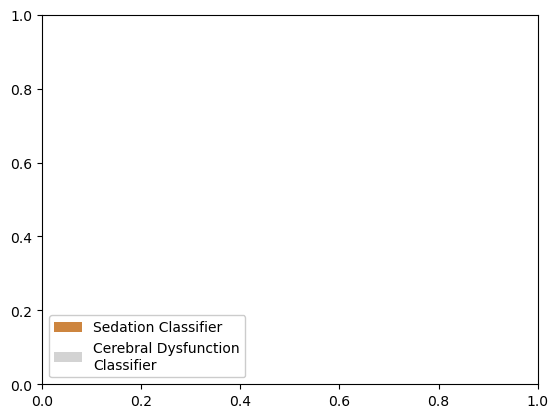

In [25]:
handles=[]
for key,color in zip([
            'Sedation Classifier',
            'Cerebral Dysfunction Classifier'],
            ['peru','lightgrey']):
    
    handles+=[mpatches.Patch(fc=color, label=key)]
    
f = lambda m,c: plt.plot([],[],marker=m, ls="none")[0]
legend = plt.legend(handles,[
         'Sedation Classifier',
            'Cerebral Dysfunction\nClassifier'], loc=3, framealpha=1, frameon=True)

In [26]:
#Feature importance values from 500 iterations of XGBoost cross-validation, computed from models' built-in gain function

with open('sedation_features_data_model_results.pickle', 'rb') as file:
    features_sedation=pickle.load(file)
    
with open('cerebral_features_data_model_results.pickle', 'rb') as file: 
    features_cerebral=pickle.load(file)
    
    
#Aggregated feature importance by pairs of body parts (i.e., feet, hands, shoulders, etc.)
sedation_feature_body_pairs=features_sedation['body part pairs']
cerebral_feature_body_pairs=features_cerebral['body part pairs']

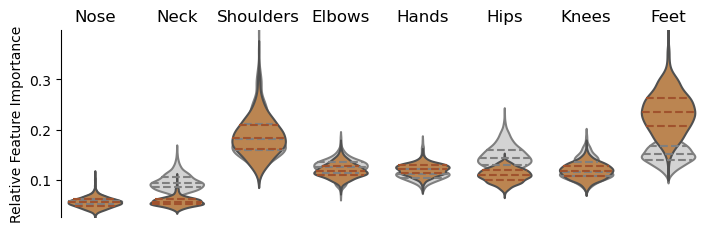

In [27]:
#Plotting violin plots denoting feature importance (relative importance of each body part) for predictions
    #in sedation and cerebral dysfunction classifiers

sedation_feature_body_pairs_adjusted = {}

for key_sedation in sedation_feature_body_pairs.keys():
    sedation_feature_body_pairs_adjusted[key_sedation] = []

for index in range(len(sedation_feature_body_pairs[list(sedation_feature_body_pairs.keys())[0]])):
    total = 0
    for key_sedation in sedation_feature_body_pairs.keys():
        total += sedation_feature_body_pairs[key_sedation][index]

    for key_sedation in sedation_feature_body_pairs.keys():
        sedation_feature_body_pairs_adjusted[key_sedation] += [sedation_feature_body_pairs[key_sedation][index] / total]
        
        
cerebral_feature_body_pairs_adjusted = {}

for key_cerebral in cerebral_feature_body_pairs.keys():
    cerebral_feature_body_pairs_adjusted[key_cerebral] = []

for index in range(len(cerebral_feature_body_pairs[list(cerebral_feature_body_pairs.keys())[0]])):
    total = 0
    for key_cerebral in cerebral_feature_body_pairs.keys():
        total += cerebral_feature_body_pairs[key_cerebral][index]

    for key_cerebral in cerebral_feature_body_pairs.keys():
        cerebral_feature_body_pairs_adjusted[key_cerebral] += [cerebral_feature_body_pairs[key_cerebral][index] / total]

        
# Create a single figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=len(sedation_feature_body_pairs_adjusted),  figsize=(7.215, 2.377))

# Initialize variables for finding common y-axis limits
y_min = float('inf')
y_max = float('-inf')

# Iterate through the dictionary items and create violin plots
for i, (key_sedation, value_sedation, key_cerebral, value_cerebral) in enumerate([(t1[0], t1[1], t2[0], t2[1]) for t1, t2 in zip(sedation_feature_body_pairs_adjusted.items(), cerebral_feature_body_pairs_adjusted.items())]):
    ax = axes[i]
    sns.violinplot(y=value_cerebral, ax=ax, color='lightgrey', inner='quart',alpha=0.6,zorder=0)  # Set the violin plot color to grey

    recorded=[]
    for line in ax.lines:
        recorded+=[line.get_ydata()[0]]
        
    sns.violinplot(y=value_sedation, ax=ax, color='peru', inner='quart',alpha=0.6,zorder=1)  # Set the violin plot color to grey


    ax.set_title(key_sedation)
    if i==0:
        ax.set_ylabel('Relative Feature Importance')

    # Calculate the median
    median_sedation = np.median(value_sedation)
    median_cerebral = np.median(value_cerebral)
    fq_sedation = first_quartile(value_sedation)
    lq_sedation = third_quartile(value_sedation)



    # Update y-axis limits
    y_min = min([y_min, min(value_sedation),min(value_cerebral)])
    y_max = max([y_max, max(value_sedation),max(value_cerebral)])

    for line in ax.lines:
            
        if np.allclose(line.get_ydata(), median_sedation):
            line.set_color('sienna')
        if np.allclose(line.get_ydata(), fq_sedation):
            line.set_color('peru')
        if np.allclose(line.get_ydata(), lq_sedation):
            line.set_color('sienna')
        if line.get_ydata()[0] not in recorded:
            line.set_color('sienna')
        line.set_linestyle('--')

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    
    if i>0:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)

# Set the same y-axis limits for all subplots
for ax in axes:
    ax.set_ylim(y_min, y_max)
# Adjust the layout to prevent overlapping headers
plt.tight_layout()